In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA  # 添加PCA导入
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载与预处理
def load_exchange_data(file_path):
    # 读取数据，指定日期列为索引
    df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
    
    print(f"数据集形状: {df.shape}")
    print(f"时间范围: {df.index.min()} 到 {df.index.max()}")
    print(f"缺失值数量: {df.isnull().sum().sum()}")
    
    return df

# 2. 探索性分析
def exploratory_analysis(df):
    # 基础统计
    print("\n目标变量(OT)统计描述:")
    print(df['OT'].describe())
    
    # 可视化目标变量时间序列
    plt.figure(figsize=(15, 6))
    df['OT'].plot(title='OT (目标变量) 时间序列')
    plt.ylabel('汇率值')
    plt.tight_layout()
    plt.savefig('OT_time_series.png')
    plt.show()
    
    # 季节性分解
    try:
        decomposition = seasonal_decompose(df['OT'].iloc[:1000], period=30)  # 分析前1000天数据
        
        # 手动创建只包含趋势、季节性和观测值的图表
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
        
        # 观测值
        decomposition.observed.plot(ax=ax1, title='观测值')
        ax1.set_ylabel('汇率值')
        
        # 趋势
        decomposition.trend.plot(ax=ax2, title='趋势')
        ax2.set_ylabel('汇率值')
        
        # 季节性
        decomposition.seasonal.plot(ax=ax3, title='季节性')
        ax3.set_ylabel('汇率值')
        
        plt.tight_layout()
        plt.savefig('seasonal_decomposition.png')
        plt.show()
    except Exception as e:
        print(f"季节性分解错误: {e}")
    
    # 选择代表性货币对
    # 计算所有货币对与OT的相关性
    corr_with_ot = df.drop('OT', axis=1).corrwith(df['OT']).sort_values()
    
    # 选择代表性货币对：高相关、中等相关、低相关各选1个
    high_corr_currency = corr_with_ot.nlargest(1).index[0]
    med_corr_currency = corr_with_ot.index[len(corr_with_ot)//2]  # 取中间位置的货币对
    low_corr_currency = corr_with_ot.nsmallest(1).index[0]
    
    # 组合代表性货币对
    representative_currencies = [high_corr_currency, med_corr_currency, low_corr_currency]
    
    print("\n选择的代表性货币对:")
    print(f"高相关性货币对: {high_corr_currency} (相关性: {corr_with_ot[high_corr_currency]:.4f})")
    print(f"中等相关性货币对: {med_corr_currency} (相关性: {corr_with_ot[med_corr_currency]:.4f})")
    print(f"低相关性货币对: {low_corr_currency} (相关性: {corr_with_ot[low_corr_currency]:.4f})")
    
    # 绘制代表性货币对汇率
    plt.figure(figsize=(15, 10))
    
    for i, currency in enumerate(representative_currencies, 1):
        plt.subplot(3, 1, i)
        df[currency].plot(title=f'{currency} 汇率 (与OT相关性: {corr_with_ot[currency]:.4f})')
        plt.ylabel('汇率值')
        plt.tight_layout()
    
    plt.savefig('representative_currency_rates.png')
    plt.show()
    
    # 箱线图分析
    # 选择分析对象：代表性货币对 + OT
    analysis_columns = representative_currencies + ['OT']
    
    # 创建水平箱线图
    plt.figure(figsize=(12, 8))
    
    # 循环绘制每个数值列的箱线图
    for i, column in enumerate(analysis_columns):
        # 计算统计信息
        mean = df[column].mean()
        std = df[column].std()
        min_val = df[column].min()
        q25 = df[column].quantile(0.25)
        median = df[column].median()
        q75 = df[column].quantile(0.75)
        max_val = df[column].max()
        
        # 创建子图
        plt.subplot(len(analysis_columns), 1, i + 1)
        
        # 绘制优化颜色的箱线图
        boxprops = dict(linestyle='-', color='#4287f5', facecolor='#a8c6fa', alpha=0.7)  # 天蓝色箱体
        whiskerprops = dict(linestyle='-', color='#2d6bc9')  # 深蓝色须线
        medianprops = dict(linestyle='-', color='#e63946')  # 红色中位数线
        meanprops = dict(marker='o', markeredgecolor='#2d6bc9', markerfacecolor='#2d6bc9')  # 蓝色均值点
        flierprops = dict(marker='o', markerfacecolor='#4287f5', markersize=6, markeredgecolor='none')  # 天蓝色异常点
        
        plt.boxplot(df[column], vert=False, widths=0.7, patch_artist=True,
                   boxprops=boxprops, whiskerprops=whiskerprops,
                   medianprops=medianprops, meanprops=meanprops,
                   flierprops=flierprops, showmeans=True)
        
        # 添加统计信息到标题
        plt.title(f'{column} 箱线图')
        plt.xlabel('汇率值')
        plt.yticks([])
        plt.grid(True, axis='x', linestyle='--', alpha=0.7, color='#cccccc')  # 浅灰色网格线
    
    plt.tight_layout()
    plt.savefig('boxplot_analysis.png')
    plt.show()
    
    # 直方图分析
    plt.figure(figsize=(12, 12))
    
    for i, column in enumerate(analysis_columns, 1):
        plt.subplot(len(analysis_columns), 1, i)
        sns.histplot(df[column], bins=50, kde=True, color='skyblue')
        plt.title(f'{column} 分布')
        plt.xlabel('汇率值')
        plt.ylabel('频率')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('histogram_analysis.png')
    plt.show()
    
    # 相关性分析
    plt.figure(figsize=(10, 8))
    corr = df[analysis_columns].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('代表性货币对汇率与OT相关性')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

# 3. 异常检测
def detect_anomalies(df):
    # 使用隔离森林检测异常
    model = IsolationForest(contamination=0.01, random_state=42)
    
    # 只使用分析列进行异常检测
    analysis_columns = df.columns.tolist()
    if 'anomaly' in analysis_columns:
        analysis_columns.remove('anomaly')
    
    anomalies = model.fit_predict(df[analysis_columns])
    df['anomaly'] = anomalies
    
    # 标记异常点
    anomalies = df[df['anomaly'] == -1]
    print(f"检测到异常点数量: {len(anomalies)}")
    
    # 可视化异常点 (以OT为例)
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['OT'], label='正常')
    plt.scatter(anomalies.index, anomalies['OT'], color='red', label='异常')
    plt.title('汇率异常检测')
    plt.legend()
    plt.savefig('anomaly_detection.png')
    plt.show()
    
    return anomalies

# 4. 多变量分析
def multivariate_analysis(df):
    # 标准化数据
    scaler = StandardScaler()
    
    # 排除异常标记列
    analysis_columns = df.columns.tolist()
    if 'anomaly' in analysis_columns:
        analysis_columns.remove('anomaly')
    
    scaled = scaler.fit_transform(df[analysis_columns])
    
    # PCA分析
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled)
    
    # 可视化PCA结果
    plt.figure(figsize=(10, 8))
    
    # 根据异常标记着色
    colors = ['blue' if x == 1 else 'red' for x in df['anomaly']]
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, alpha=0.6)
    
    plt.xlabel('PC1 (解释方差: {:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
    plt.ylabel('PC2 (解释方差: {:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
    plt.title('PCA分析 - 汇率数据集')
    plt.savefig('pca_analysis.png')
    plt.show()
    
    # 特征重要性
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=analysis_columns
    )
    print("\nPCA特征载荷:")
    print(loadings)

# 主程序
if __name__ == "__main__":
    # 加载数据
    file_path = "exchange_rate.csv"  # 根据实际路径修改
    df = load_exchange_data(file_path)
    
    # 探索性分析
    exploratory_analysis(df)
    
    # 异常检测
    anomalies = detect_anomalies(df)
    
    # 多变量分析
    multivariate_analysis(df)

数据集形状: (7588, 8)
时间范围: 1990-01-01 00:00:00 到 2010-10-10 00:00:00
缺失值数量: 0

目标变量(OT)统计描述:
count    7588.000000
mean        0.654418
std         0.115292
min         0.393153
25%         0.566000
50%         0.669187
75%         0.734901
max         0.882379
Name: OT, dtype: float64


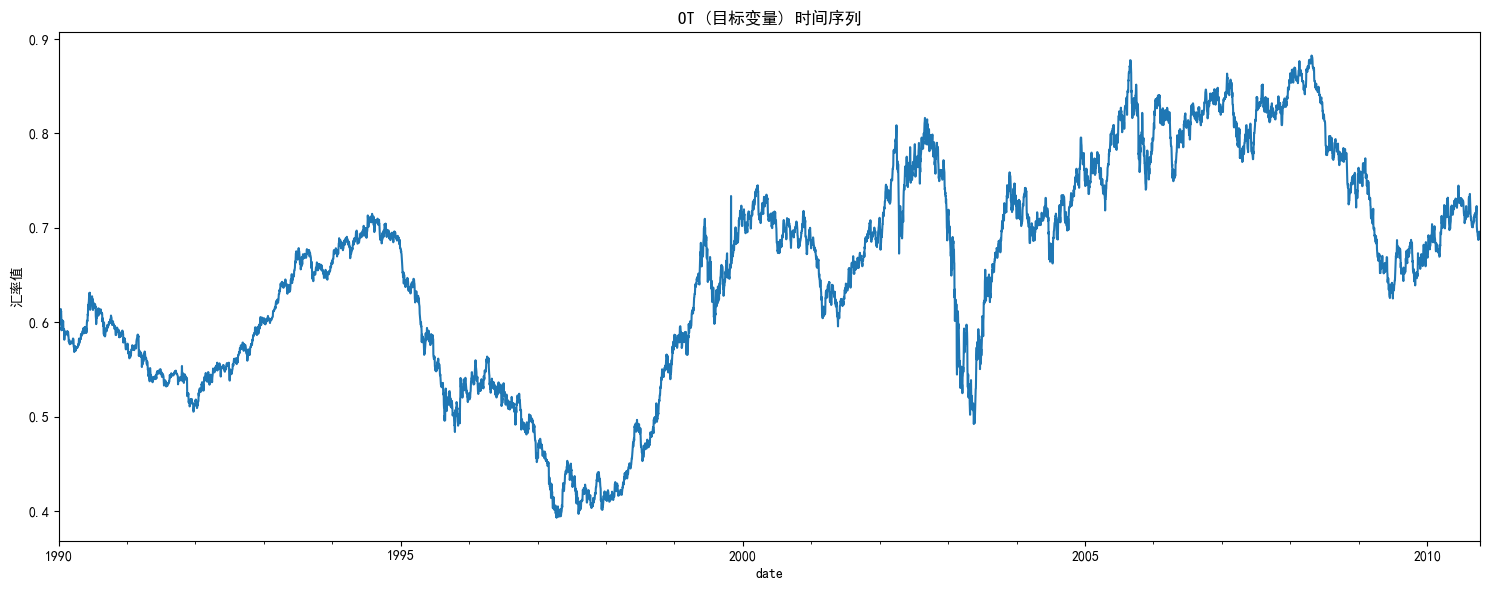

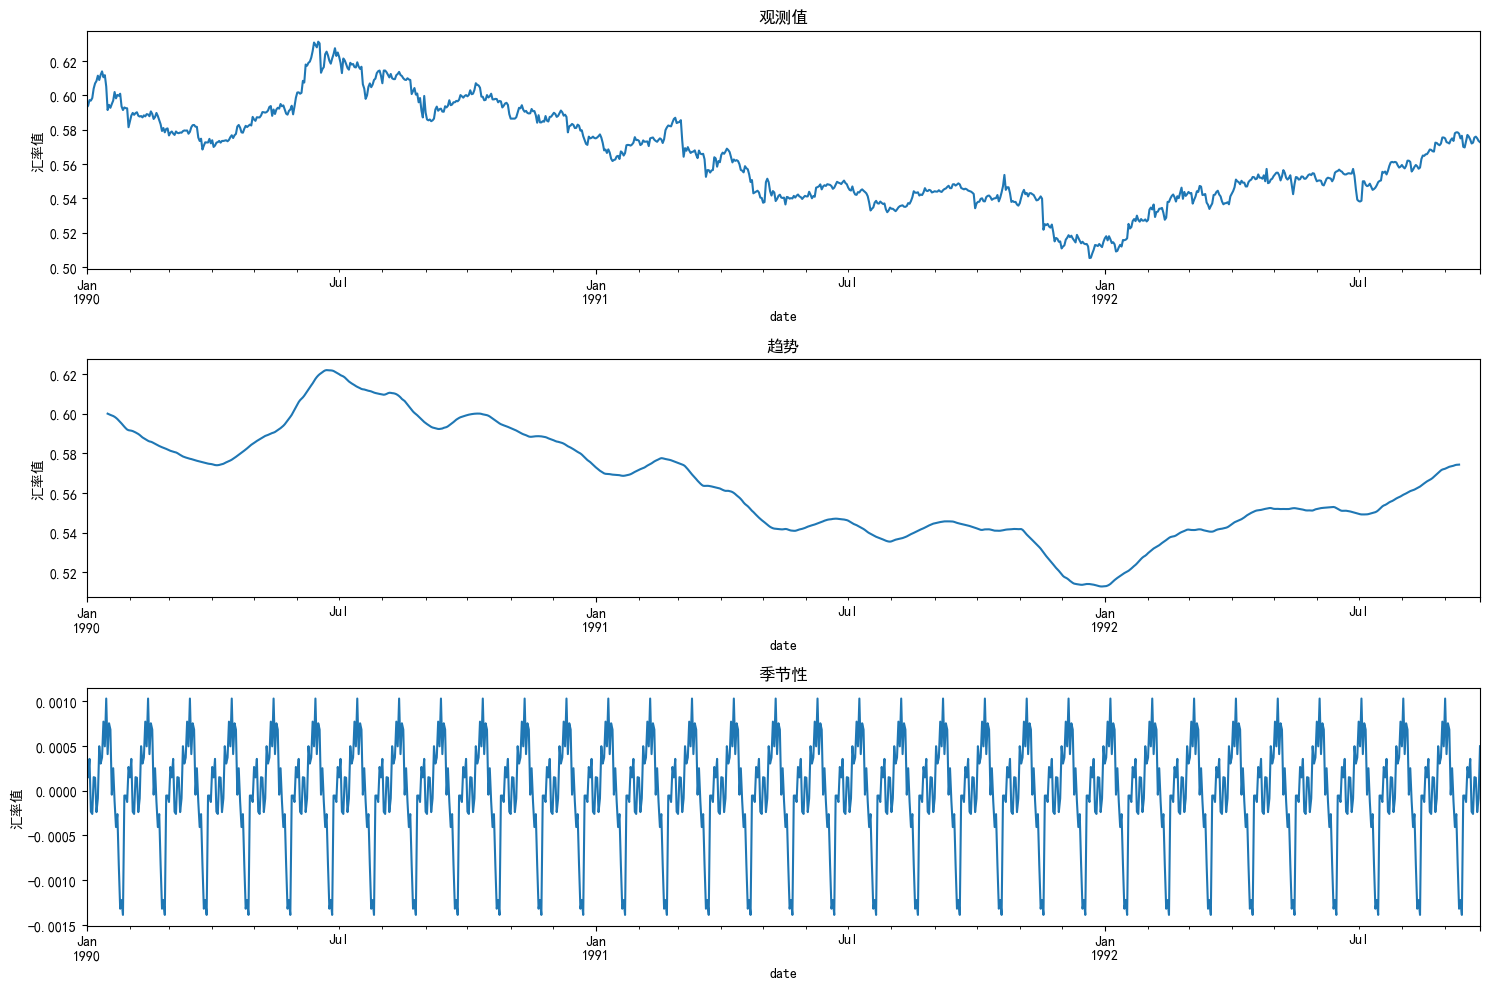


选择的代表性货币对:
高相关性货币对: 0 (相关性: 0.9006)
中等相关性货币对: 2 (相关性: 0.7760)
低相关性货币对: 1 (相关性: 0.2014)


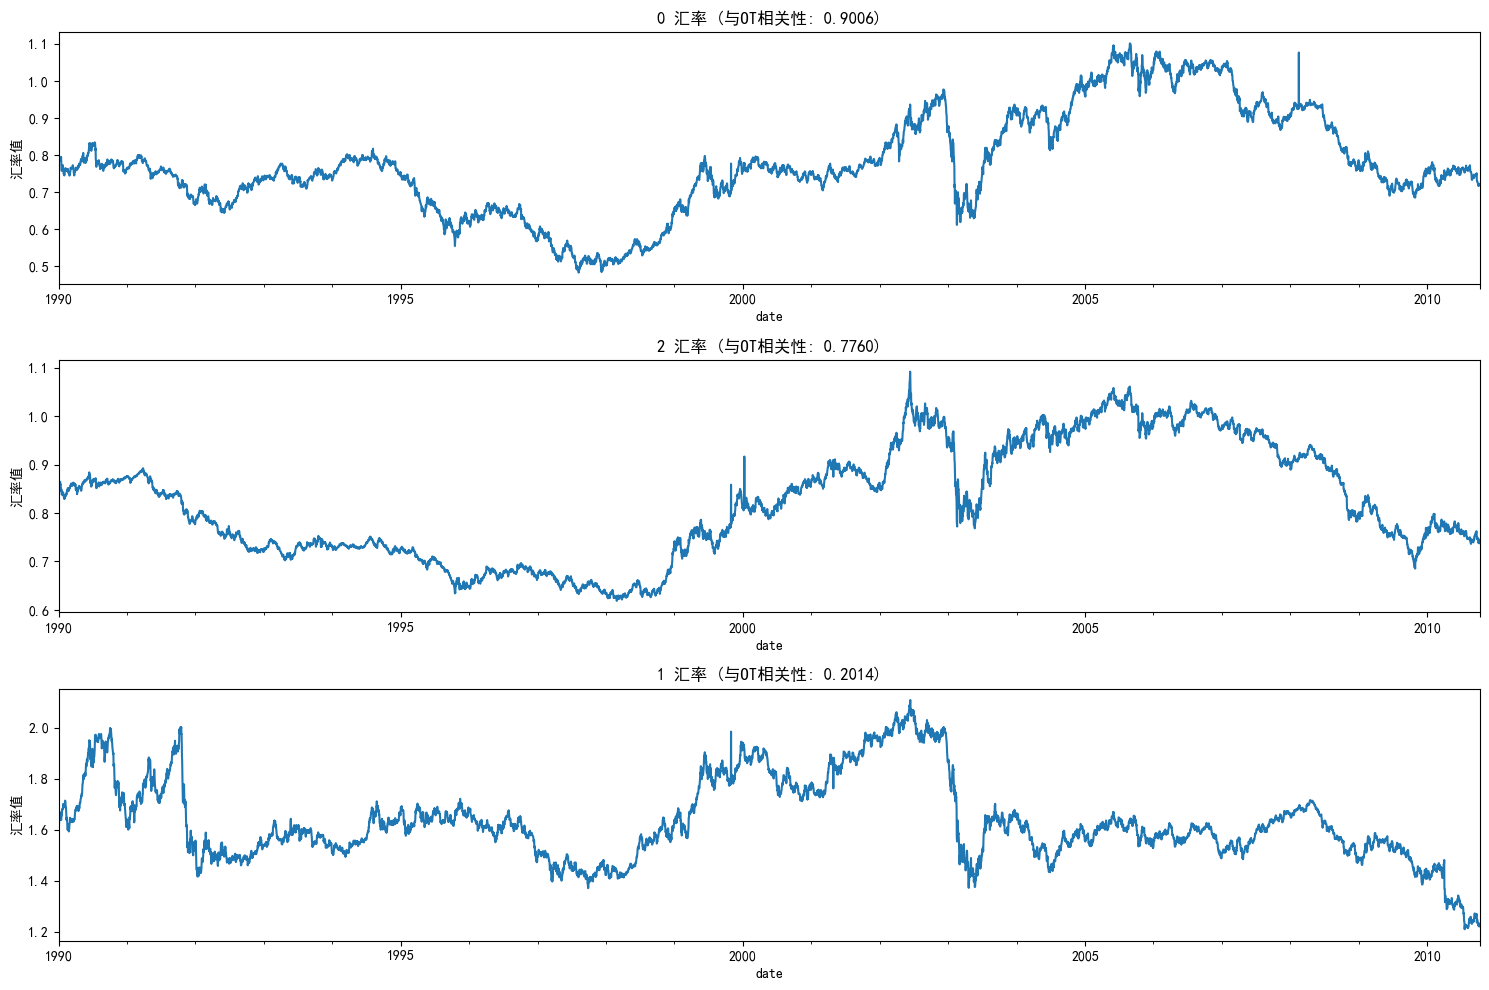

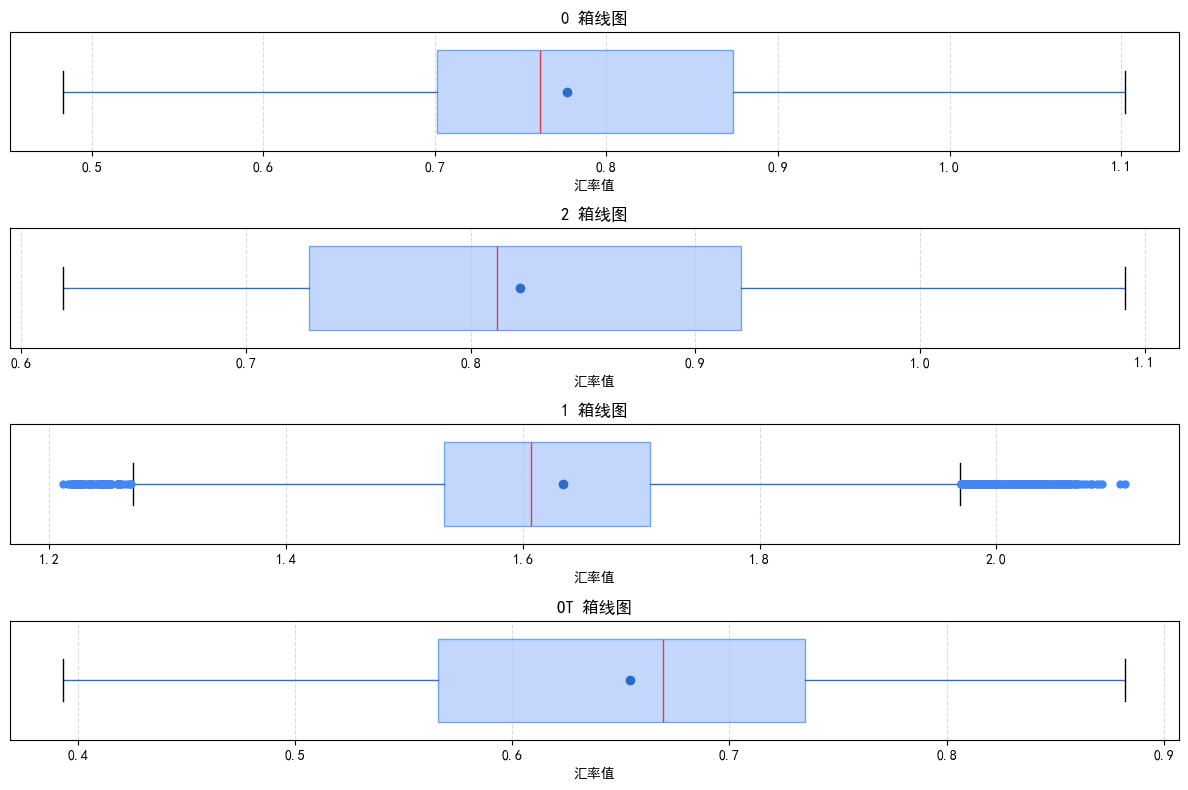

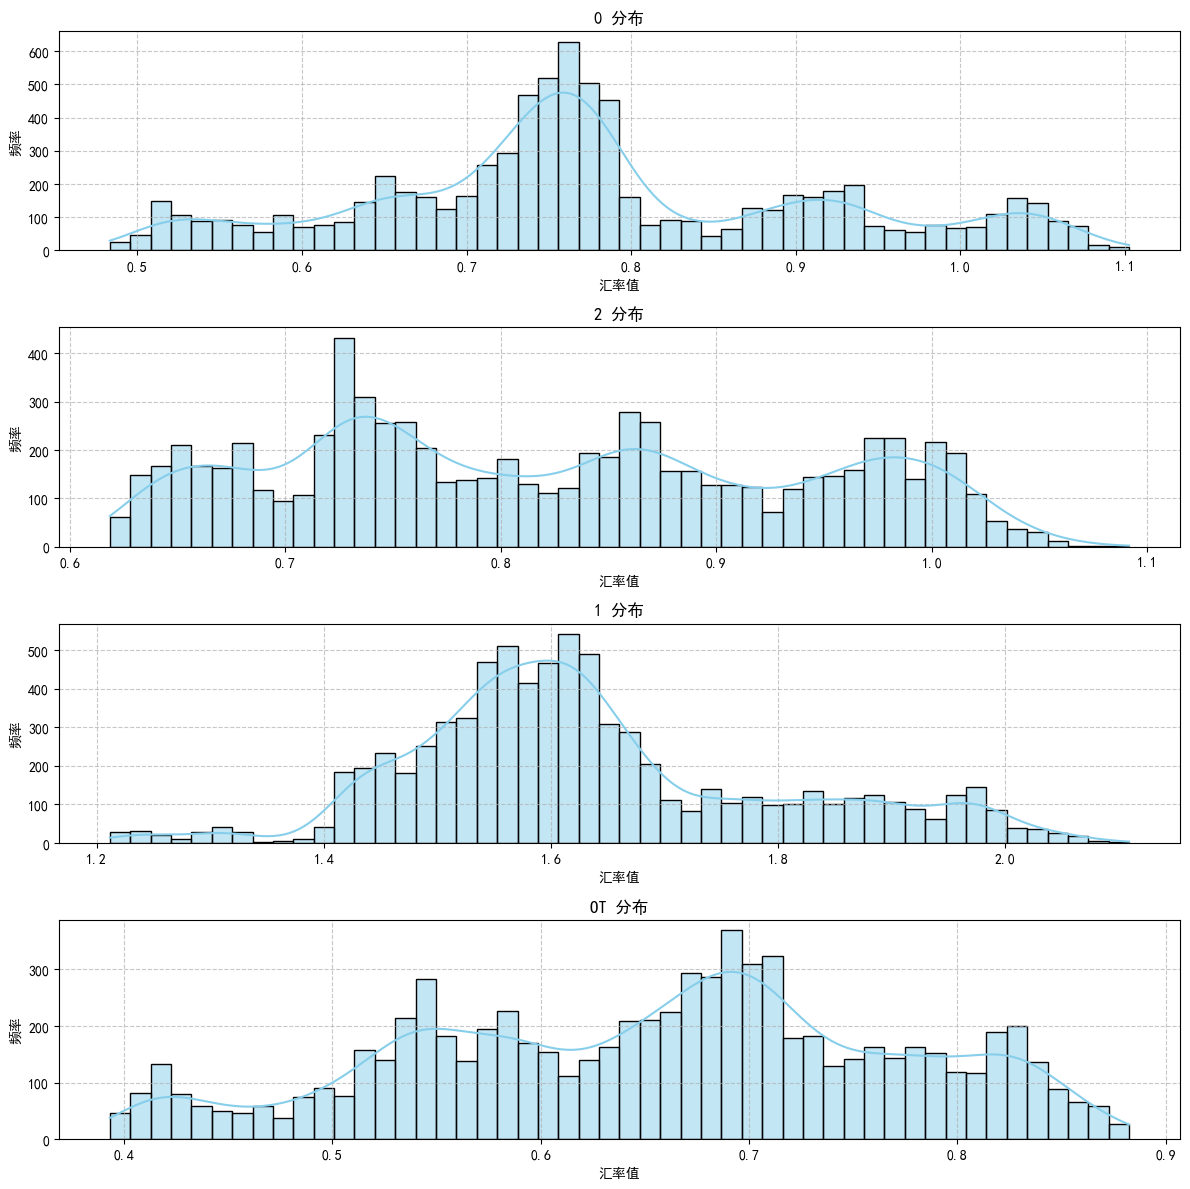

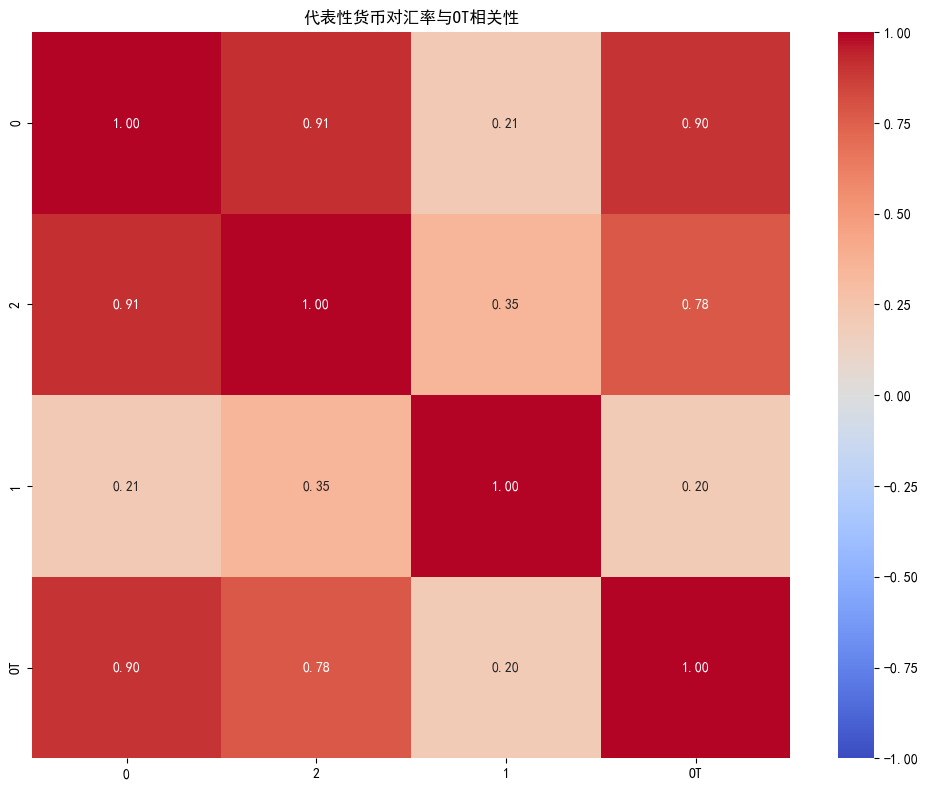

检测到异常点数量: 76


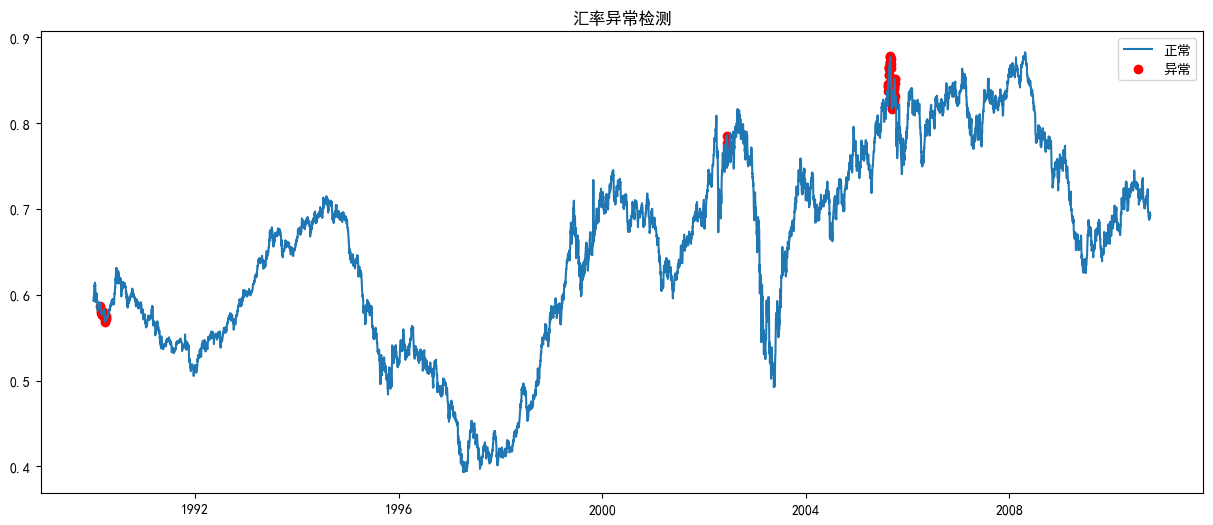

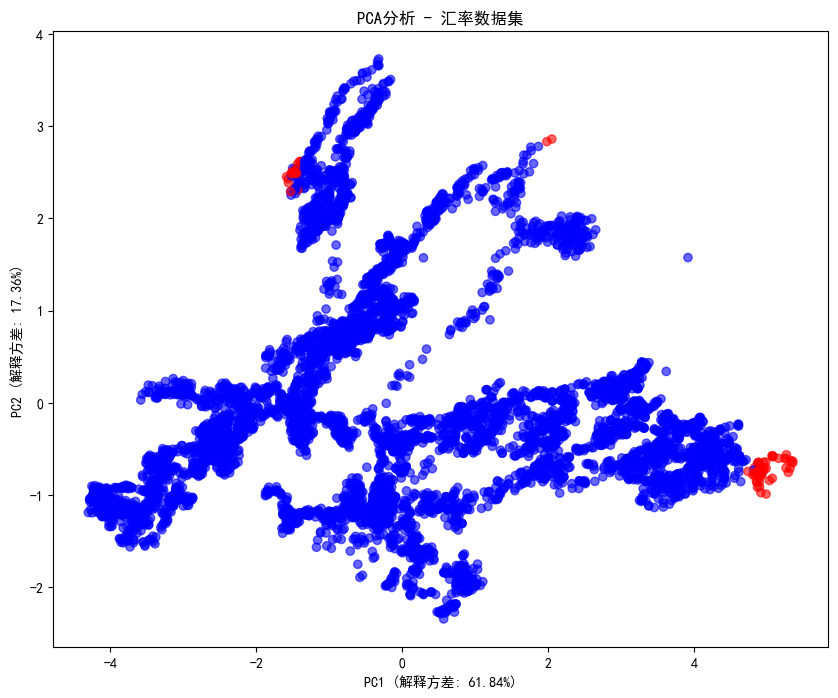


PCA特征载荷:
         PC1       PC2
0   0.433675  0.117153
1   0.041474  0.721964
2   0.397678  0.287658
3   0.415004 -0.126484
4   0.183581  0.376025
5   0.323656 -0.394299
6   0.408956 -0.258367
OT  0.417288  0.051747
